## Importing libraries

In [1]:
from collections import Counter

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

#from wordcloud import WordCloud, STOPWORDS 

from scipy.sparse import hstack

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
from sklearn.linear_model import LogisticRegression, RidgeClassifier, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


In [2]:
# reading dataset
train = pd.read_csv('train-balanced-sarcasm.csv')
test = pd.read_csv('test-unbalanced.csv')

In [3]:
train.head(10)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
5,0,"I don't pay attention to her, but as long as s...",only7inches,AskReddit,0,0,0,2016-09,2016-09-02 10:35:08,do you find ariana grande sexy ?
6,0,Trick or treating in general is just weird...,only7inches,AskReddit,1,-1,-1,2016-10,2016-10-23 21:43:03,What's your weird or unsettling Trick or Treat...
7,0,Blade Mastery+Masamune or GTFO!,P0k3rm4s7,FFBraveExvius,2,-1,-1,2016-10,2016-10-13 21:13:55,Probably Sephiroth. I refuse to taint his grea...
8,0,"You don't have to, you have a good build, buy ...",SoupToPots,pcmasterrace,1,-1,-1,2016-10,2016-10-27 19:11:06,What to upgrade? I have $500 to spend (mainly ...
9,0,I would love to see him at lolla.,chihawks,Lollapalooza,2,-1,-1,2016-11,2016-11-21 23:39:12,Probably count Kanye out Since the rest of his...


## Pre-Processing

In [4]:
#checking null valued coulmns
train.isna().sum()

label              0
comment           53
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

In [5]:
#removing null values
train_without_na = train.dropna(subset=['comment']).iloc[0:20000,:]
train_without_na.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 10 columns):
label             20000 non-null int64
comment           20000 non-null object
author            20000 non-null object
subreddit         20000 non-null object
score             20000 non-null int64
ups               20000 non-null int64
downs             20000 non-null int64
date              20000 non-null object
created_utc       20000 non-null object
parent_comment    20000 non-null object
dtypes: int64(4), object(6)
memory usage: 1.7+ MB


## Data Exploration

In [6]:
train.describe() #used to view some basic statistical details like percentile, mean, std etc. of a data frame 

,label,score,ups,downs
count,1010826.0,1.010826e+06,1.010826e+06,1.010826e+06
mean,0.5,6.885676e+00,5.498885e+00,-1.458629e-01
std,0.5,4.834288e+01,4.127297e+01,3.529689e-01
min,0.0,-5.070000e+02,-5.070000e+02,-1.000000e+00
25%,0.0,1.000000e+00,0.000000e+00,0.000000e+00
50%,0.5,2.000000e+00,1.000000e+00,0.000000e+00
75%,1.0,4.000000e+00,3.000000e+00,0.000000e+00
max,1.0,9.070000e+03,5.163000e+03,0.000000e+00


In [7]:
train_without_na.shape  # number of rows and columns
train_without_na['label'].value_counts()

#0 non sarcastic
#1 sarcastic

0    12248
1     7752
Name: label, dtype: int64

In [8]:
# size implies number of comments written by a particular author
# sum implies number of comments belonging to class 1(sarcastic)
# mean implies sum/size
# if mean < 0.5 majority comments are non sarcastic 
# if mean >= 0.5 majority comments are sarcastic


train_without_na.groupby('author')['label'].agg([np.size, np.mean, np.sum]).sort_values(by='sum', ascending=False)

,size,mean,sum
author,,,
sleaze_bag_alert,20,0.600000,12
TouchMeHerePls,15,0.466667,7
mad-n-fla,10,0.700000,7
EggCouncil,11,0.636364,7
Vince5970,16,0.375000,6
...,...,...,...
WildFunkyFresh,1,0.000000,0
Geaux_Cajuns,1,0.000000,0
Wildfires,1,0.000000,0


In [9]:
# size implies number of comments belonging a subreddit
# sum implies number of comments belonging to class 1(sarcastic)
# mean implies sum/size
# if mean < 0.5 majority comments are non sarcastic 
# if mean >= 0.5 majority comments are sarcastic

train_without_na.groupby('subreddit')['label'].agg([np.size, np.mean, np.sum]).sort_values(by='sum', ascending=False)

,size,mean,sum
subreddit,,,
politics,1266,0.530806,672
AskReddit,1304,0.304448,397
The_Donald,540,0.396296,214
worldnews,366,0.524590,192
pcmasterrace,337,0.448071,151
...,...,...,...
ToolBand,1,0.000000,0
TooMeIrlForMeIrl,1,0.000000,0
TooAfraidToAsk,1,0.000000,0


In [10]:
# size implies number of comments with a particular score>0
# sum implies number of comments belonging to class 1(sarcastic)
# mean implies sum/size
# if mean < 0.5 majority comments are non sarcastic 
# if mean >= 0.5 majority comments are sarcastic

train_without_na[train_without_na['score'] >= 0].groupby('score')['label'].agg([np.size, np.mean, np.sum]).sort_values(by='sum', ascending=False)

,size,mean,sum
score,,,
1,6980,0.336676,2350
2,3320,0.372289,1236
3,1766,0.396942,701
0,811,0.491985,399
4,857,0.434072,372
...,...,...,...
223,1,0.000000,0
105,3,0.000000,0
209,1,0.000000,0


In [11]:
# size implies number of comments with a particular score<0
# sum implies number of comments belonging to class 1(sarcastic)
# mean implies sum/size
# if mean < 0.5 majority comments are non sarcastic 
# if mean >= 0.5 majority comments are sarcastic

train_without_na[train_without_na['score'] < 0].groupby('score')['label'].agg([np.size, np.mean, np.sum]).sort_values(by='sum', ascending=False)

,size,mean,sum
score,,,
-1,310,0.570968,177
-2,147,0.564626,83
-3,100,0.540000,54
-4,72,0.527778,38
-5,54,0.555556,30
-6,50,0.480000,24
-8,31,0.645161,20
-7,30,0.533333,16
-9,21,0.571429,12


## Data visualization

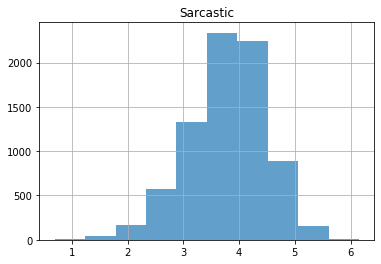

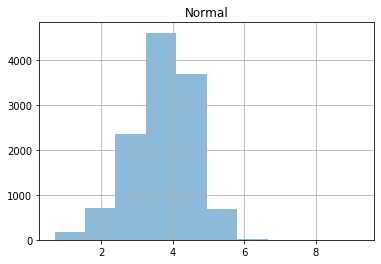

In [12]:
# Distribution of lengths for sarcastic and normal comments is almost the same

train_without_na.loc[train_without_na['label'] == 1, 'comment'].str.len().apply(np.log1p).hist(label='sarcastic', alpha=.7)
plt.title('Sarcastic')
plt.show()
train_without_na.loc[train_without_na['label'] == 0, 'comment'].str.len().apply(np.log1p).hist(label='normal', alpha=.5)
plt.title('Normal')
plt.show()


#hence length of the comment cannot determine class

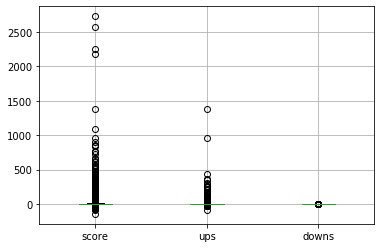

In [13]:
# Counting the outliers for each column in dataset
Q1 = train_without_na.quantile(0.25)
Q3 = train_without_na.quantile(0.75)
IQR = Q3 - Q1
((train_without_na < (Q1 - 1.5 * IQR)) | (train_without_na > (Q3 + 1.5 * IQR))).sum()

#boxplot to show the outliers in score ups and downs
boxplot = train_without_na.boxplot(column=['score', 'ups', 'downs'])

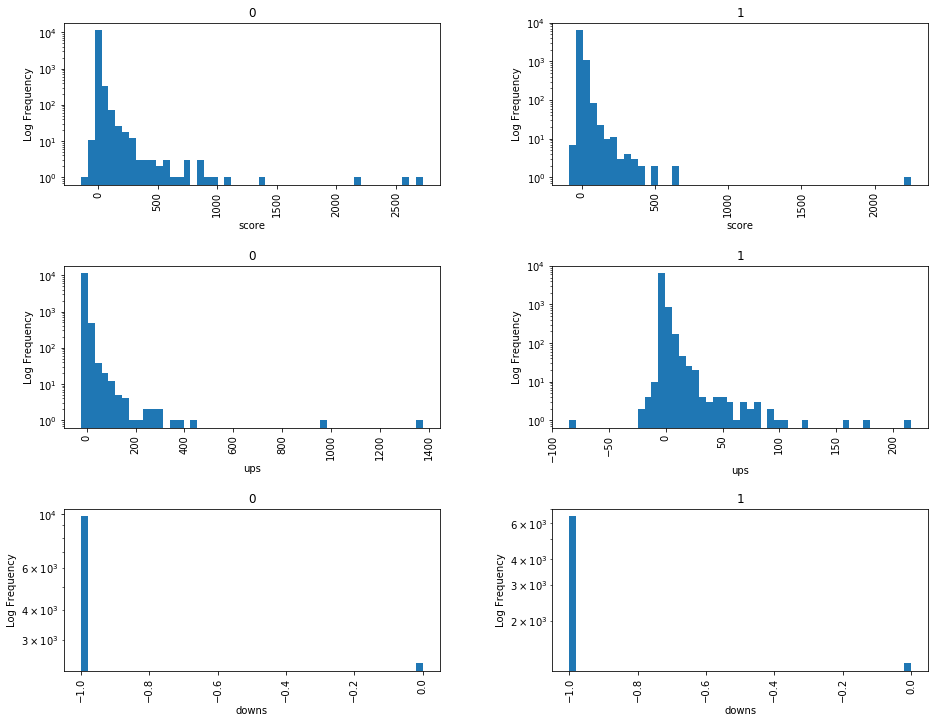

In [14]:
# Plots to show frequencies of score,upvotes and downvotes for both the classes 0 and 1. 

fig, ax = plt.subplots(nrows=3, ncols=2, squeeze=False, figsize=(15, 12))

feature_id = 0

feature_list = ['score', 'ups', 'downs']

for row in ax:
    feature = feature_list[feature_id]
    
    axes = row.flatten()
    train_without_na.hist(ax=axes, column=feature, by='label', bins=50, log=True,)

    axes[0].set_xlabel(feature)
    axes[0].set_ylabel('Log Frequency')

    axes[1].set_xlabel(feature)
    axes[1].set_ylabel('Log Frequency')

    feature_id += 1

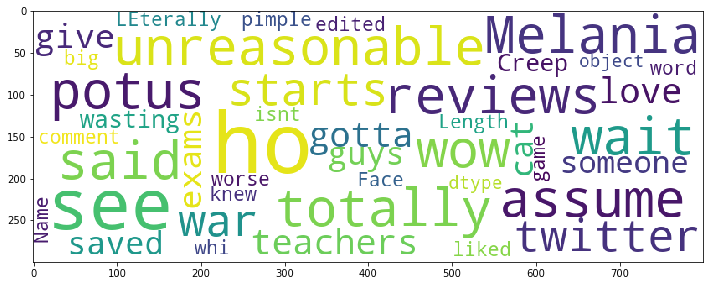

In [15]:
# Word Cloud is a data visualization technique used for representing text data in 
# which the size of each word indicates its frequency or importance.
# Significant textual data points can be highlighted using a word cloud.
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(background_color='white', stopwords = STOPWORDS,
                max_words = 200, max_font_size = 100, 
                random_state = 17, width=800, height=300)

# word cloud for words in sarcastic comments
plt.figure(figsize=(12, 12))
wordcloud.generate(str(train_without_na.loc[train_without_na['label'] == 1, 'comment']))
plt.imshow(wordcloud);

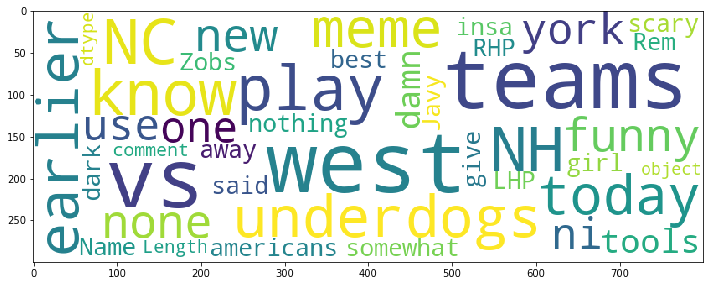

In [16]:
# word cloud for words in non sarcastic comments
plt.figure(figsize=(12, 12))
wordcloud.generate(str(train_without_na.loc[train_without_na['label'] == 0, 'comment']))
plt.imshow(wordcloud);

## Vectorization

In [17]:
train_removed_features = train_without_na.iloc[:, :-3].drop('author', axis=1)
train_removed_features.head(10)


,label,comment,subreddit,score,ups,downs
0,0,NC and NH.,politics,2,-1,-1
1,0,You do know west teams play against west teams...,nba,-4,-1,-1
2,0,"They were underdogs earlier today, but since G...",nfl,3,3,0
3,0,"This meme isn't funny none of the ""new york ni...",BlackPeopleTwitter,-8,-1,-1
4,0,I could use one of those tools.,MaddenUltimateTeam,6,-1,-1
5,0,"I don't pay attention to her, but as long as s...",AskReddit,0,0,0
6,0,Trick or treating in general is just weird...,AskReddit,1,-1,-1
7,0,Blade Mastery+Masamune or GTFO!,FFBraveExvius,2,-1,-1
8,0,"You don't have to, you have a good build, buy ...",pcmasterrace,1,-1,-1
9,0,I would love to see him at lolla.,Lollapalooza,2,-1,-1


In [18]:
#Removing label
train_x, train_y = train_removed_features.drop('label', axis=1), train_removed_features['label']

print(train_y)

0        0
1        0
2        0
3        0
4        0
        ..
19995    0
19996    1
19997    1
19998    1
19999    1
Name: label, Length: 20000, dtype: int64


In [19]:
# Build bigrams, put a limit on maximal number of features
# and minimal word frequency
#Vectorization of features using TF-IDF Vectorizer
#It is a very common algorithm to transform the text into a meaningful representation of numbers.
#The technique is widely used to extract features across various NLP applications.
#Vectorization of comments


tfidf_comment = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
comment_sparse = tfidf_comment.fit_transform(train_x['comment'])
print(comment_sparse)

  (0, 178)	1.0
  (1, 2618)	0.20016341530232395
  (1, 4917)	0.2213241887343692
  (1, 3313)	0.14581849303452665
  (1, 1142)	0.23943570106420126
  (1, 3832)	0.14878237244484468
  (1, 2615)	0.14016638250846528
  (1, 100)	0.18589741223871253
  (1, 3057)	0.17305317442441343
  (1, 3811)	0.6819608606761816
  (1, 4649)	0.4642227428846061
  (1, 2234)	0.1429245923488613
  (1, 1028)	0.13353473876687075
  (1, 4903)	0.08507248996147249
  (2, 4107)	0.3287916262392798
  (2, 4206)	0.13025279935395692
  (2, 2629)	0.40743004066491373
  (2, 1666)	0.23275586826051342
  (2, 2349)	0.34064338044506304
  (2, 3913)	0.10852807926709013
  (2, 4135)	0.17379209793584147
  (2, 3525)	0.28958834046360377
  (2, 615)	0.17549093884123926
  (2, 4302)	0.3525139236509166
  (2, 1136)	0.39728461641936946
  :	:
  (19996, 4813)	0.39640241923625213
  (19996, 4827)	0.39495282249543984
  (19996, 1992)	0.16109497279182505
  (19996, 3913)	0.12073531785046447
  (19996, 3832)	0.27065710692422906
  (19997, 2232)	0.3804171928344195
  (1

In [20]:
#Vectorization of subreddits
tfidf_subreddit = TfidfVectorizer(ngram_range=(1, 1), max_features=50000)
subreddit_sparse = tfidf_subreddit.fit_transform(train_x['subreddit'])
print(subreddit_sparse)

  (0, 1799)	1.0
  (1, 1544)	1.0
  (2, 1577)	1.0
  (3, 298)	1.0
  (4, 1363)	1.0
  (5, 151)	1.0
  (6, 151)	1.0
  (7, 828)	1.0
  (8, 1716)	1.0
  (9, 1337)	1.0
  (10, 1799)	1.0
  (11, 224)	1.0
  (12, 792)	1.0
  (13, 813)	1.0
  (14, 1635)	1.0
  (15, 151)	1.0
  (16, 1564)	1.0
  (17, 1799)	1.0
  (18, 1075)	1.0
  (19, 2179)	1.0
  (20, 2473)	1.0
  (21, 2451)	1.0
  (22, 1799)	1.0
  (23, 1799)	1.0
  (24, 3)	1.0
  :	:
  (19975, 515)	1.0
  (19976, 2006)	1.0
  (19977, 1753)	1.0
  (19978, 989)	1.0
  (19979, 225)	1.0
  (19980, 2147)	1.0
  (19981, 1074)	1.0
  (19982, 236)	1.0
  (19983, 2319)	1.0
  (19984, 989)	1.0
  (19985, 2441)	1.0
  (19986, 989)	1.0
  (19987, 234)	1.0
  (19988, 1780)	1.0
  (19989, 1618)	1.0
  (19990, 2144)	1.0
  (19991, 858)	1.0
  (19992, 1414)	1.0
  (19993, 1603)	1.0
  (19994, 255)	1.0
  (19995, 448)	1.0
  (19996, 468)	1.0
  (19997, 1864)	1.0
  (19998, 493)	1.0
  (19999, 2487)	1.0


In [21]:
#Length of comments
print(len(tfidf_comment.vocabulary_))

5000


In [22]:
cont_var = train_x.iloc[:,-3:]
scaler = StandardScaler()
scaled_cont_var = scaler.fit_transform(cont_var)

In [23]:
#hstack() function is used to stack the sequence of input arrays horizontally (i.e. column wise) to make a single array. 
train_x_sparse = hstack([comment_sparse, subreddit_sparse, scaled_cont_var])


### Splitting the data set

In [37]:
# Splitting the data into training dataset and test dataset
x_train, x_test, y_train, y_test = train_test_split(train_x_sparse, train_y,test_size = .4)

### Model 1:Logistic Regression

In [25]:
#Apply logistic regression classifier
clf = LogisticRegression(solver='liblinear', verbose=True)

In [26]:
clf.fit(x_train, y_train)

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001,
                   verbose=True, warm_start=False)

In [27]:
#Finding accuracy score of training dataset
clf.score(x_train, y_train)

0.8015833333333333

In [28]:
#Finding accuracy score of test dataset
clf.score(x_test, y_test)

0.6795

In [29]:
#Predicting test dataset
y_pred = clf.predict(x_test)

In [30]:
#Confusion Matrix to describe the performance of a classification model 
cf_matrix = confusion_matrix(y_pred=y_pred, y_true=y_test)

Text(0.5, 1, 'Confusion Matrix')

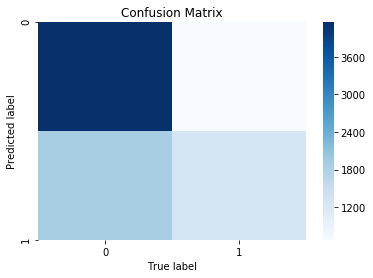

In [31]:
#A heatmap is a two-dimensional graphical representation of data where the individual values
#that are contained in a matrix are represented as colors. 
sns.heatmap(cf_matrix, cmap='Blues')
plt.ylabel('Predicted label')
plt.xlabel('True label')
plt.title('Confusion Matrix')

### Model 2: Naive Bayes

In [32]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(x_train.todense(), y_train)
print(gnb.score(x_train.todense(), y_train))
print(gnb.score(x_test.todense(), y_test))    



0.6333333333333333
0.492


In [34]:
y_pred = gnb.predict(x_test.todense())

In [35]:
#Confusion Matrix to describe the performance of a classification model 
cf_matrix = confusion_matrix(y_pred=y_pred, y_true=y_test)

Text(0.5, 1, 'Confusion Matrix')

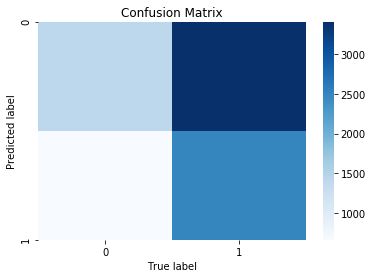

In [36]:
#A heatmap is a two-dimensional graphical representation of data where the individual values
#that are contained in a matrix are represented as colors. 
sns.heatmap(cf_matrix, cmap='Blues')
plt.ylabel('Predicted label')
plt.xlabel('True label')
plt.title('Confusion Matrix')

#1 positive class(sarcastic)
#0 negative class(non-sarcastic)
#count of false negatives is comparitively higher then other windows(1,2)
